In [3]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
# Suppress warnings for cleaner output (optional, but matches the notebook)
warnings.filterwarnings('ignore')

# --- Helper Function to Evaluate Model ---
def evaluate_model(model, X_data, Y_data, dataset_name="Test"):
    """Calculates and returns common classification metrics."""
    try:
        Y_pred = model.predict(X_data)
        metrics = {
            f"{dataset_name} Accuracy": accuracy_score(Y_data, Y_pred),
            # Add zero_division=0 to handle cases where a class is not predicted
            # f"{dataset_name} Precision": precision_score(Y_data, Y_pred, average='weighted', zero_division=0),
            # f"{dataset_name} Recall": recall_score(Y_data, Y_pred, average='weighted', zero_division=0),
            # f"{dataset_name} F1 Score": f1_score(Y_data, Y_pred, average='weighted', zero_division=0),
        }
    except Exception as e:
        print(f"Error evaluating model {model.__class__.__name__} on {dataset_name} data: {e}")
        metrics = {
            f"{dataset_name} Accuracy": "Error",
            # f"{dataset_name} Precision": "Error",
            # f"{dataset_name} Recall": "Error",
            # f"{dataset_name} F1 Score": "Error",
        }
    return metrics

# --- Main Function to Run All Models ---
def evaluate_models_on_data(X, Y, test_size=0.2, random_state=42, max_knn_neighbors=9):
    """
    Performs train-test split, trains and evaluates multiple classifiers
    (Logistic Regression, SVM, KNN) on the provided data.

    Args:
        X (pd.DataFrame or np.ndarray): Feature data.
        Y (pd.Series or np.ndarray): Target data.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Controls the shuffling applied to the data before splitting
                             and the randomness of estimators.
        max_knn_neighbors (int): Maximum number of neighbors to test for KNN.
    """

    print(f"Starting model evaluation with test_size={test_size}, random_state={random_state}")
    print("-" * 70)

    # Ensure Y is a 1D array (required by many scikit-learn estimators)
    if isinstance(Y, pd.Series) or isinstance(Y, pd.DataFrame):
        Y_flat = Y.values.ravel()
    else:
        Y_flat = Y.ravel()

    # 1. Train-Test Split
    try:
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y_flat, test_size=test_size, random_state=random_state, stratify=Y_flat
        )
        print(f"Data split: Train shape={X_train.shape}, Test shape={X_test.shape}")
        print("-" * 70)
    except Exception as e:
        print(f"Error during train-test split: {e}")
        print("Cannot proceed with model evaluation.")
        return

    all_results = {}

    # 2. Logistic Regression
    print("Evaluating Logistic Regression...")
    model_lr = LogisticRegression(random_state=random_state, max_iter=10000, n_jobs=-1) # Increased max_iter as in notebook
    try:
        model_lr.fit(X_train, Y_train)
        train_metrics = evaluate_model(model_lr, X_train, Y_train, "Train")
        test_metrics = evaluate_model(model_lr, X_test, Y_test, "Validation")
        all_results['Logistic Regression'] = {**train_metrics, **test_metrics}
        print(f"Train Metrics: {train_metrics}")
        print(f"Validation Metrics: {test_metrics}")
    except Exception as e:
        print(f"Error training/evaluating Logistic Regression: {e}")
        all_results['Logistic Regression'] = {"Status": "Error"}
    print("-" * 70)

    # 3. SVM Models
    svm_kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    for kernel in svm_kernels:
        print(f"Evaluating SVM with kernel='{kernel}'...")
        model_svm = svm.SVC(kernel=kernel, random_state=random_state, probability=True) # probability=True can be useful but slower
        try:
            model_svm.fit(X_train, Y_train)
            train_metrics = evaluate_model(model_svm, X_train, Y_train, "Train")
            test_metrics = evaluate_model(model_svm, X_test, Y_test, "Validation")
            result_key = f'SVM (kernel={kernel})'
            all_results[result_key] = {**train_metrics, **test_metrics}
            print(f"Train Metrics: {train_metrics}")
            print(f"Validation Metrics: {test_metrics}")
        except Exception as e:
             print(f"Error training/evaluating SVM (kernel={kernel}): {e}")
             all_results[f'SVM (kernel={kernel})'] = {"Status": "Error"}
        print("-" * 70)

    # 4. KNN Models
    print("Evaluating K-Nearest Neighbors...")
    for i in range(1, max_knn_neighbors + 1,3):
        print(f"  KNN with n_neighbors={i}")
        # Using 'auto' might be more efficient generally, but keeping 'ball_tree' as per notebook
        model_knn = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
        try:
            model_knn.fit(X_train, Y_train)
            train_metrics = evaluate_model(model_knn, X_train, Y_train, "Train")
            test_metrics = evaluate_model(model_knn, X_test, Y_test, "Validation")
            result_key = f'KNN (n_neighbors={i})'
            all_results[result_key] = {**train_metrics, **test_metrics}
            print(f"  Train Metrics: {train_metrics}")
            print(f"  Validation Metrics: {test_metrics}")
        except Exception as e:
            print(f"  Error training/evaluating KNN (n_neighbors={i}): {e}")
            all_results[f'KNN (n_neighbors={i})'] = {"Status": "Error"}
        print("  " + "-" * 68) # Indented separator
    print("-" * 70)
    print("Model evaluation complete.")

    # Optionally return the results
    # return all_results

# --- Example Usage ---
# Load your data first (as in the notebook)
df = pd.read_csv('../data/EEG data.csv')
df = df.iloc[:,1:] # Remove the first column if it's just an index

# Separate features (X) and target (Y)
X_original = df.iloc[:,:-1]
Y_original = df.iloc[:,-1]

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_original)

# Convert back to DataFrame with original column names
X_normalized = pd.DataFrame(X_normalized, columns=X_original.columns)

# Now call the function with your original data
evaluate_models_on_data(X_normalized, Y_original, random_state=42) # Using same random_state as notebook

Starting model evaluation with test_size=0.2, random_state=42
----------------------------------------------------------------------
Data split: Train shape=(32, 320), Test shape=(8, 320)
----------------------------------------------------------------------
Evaluating Logistic Regression...
Train Metrics: {'Train Accuracy': 1.0}
Validation Metrics: {'Validation Accuracy': 0.125}
----------------------------------------------------------------------
Evaluating SVM with kernel='linear'...
Train Metrics: {'Train Accuracy': 1.0}
Validation Metrics: {'Validation Accuracy': 0.375}
----------------------------------------------------------------------
Evaluating SVM with kernel='poly'...
Train Metrics: {'Train Accuracy': 0.625}
Validation Metrics: {'Validation Accuracy': 0.25}
----------------------------------------------------------------------
Evaluating SVM with kernel='rbf'...
Train Metrics: {'Train Accuracy': 0.6875}
Validation Metrics: {'Validation Accuracy': 0.375}
------------------

In [5]:
def evaluate_models_on_data_mod(X, Y,selector, test_size=0.2, random_state=42, max_knn_neighbors=9):
    """
    Performs train-test split, trains and evaluates multiple classifiers
    (Logistic Regression, SVM, KNN) on the provided data.

    Args:
        X (pd.DataFrame or np.ndarray): Feature data.
        Y (pd.Series or np.ndarray): Target data.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Controls the shuffling applied to the data before splitting
                             and the randomness of estimators.
        max_knn_neighbors (int): Maximum number of neighbors to test for KNN.
    """

    print(f"Starting model evaluation with test_size={test_size}, random_state={random_state}")
    print("-" * 70)

    # Ensure Y is a 1D array (required by many scikit-learn estimators)
    if isinstance(Y, pd.Series) or isinstance(Y, pd.DataFrame):
        Y_flat = Y.values.ravel()
    else:
        Y_flat = Y.ravel()

    # 1. Train-Test Split
    try:
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y_flat, test_size=test_size, random_state=random_state, stratify=Y_flat
        )
        selector.fit(X_train,Y_train)
        X_train = selector.transform(X_train)
        X_test = selector.transform(X_test)
        print(f"Data split: Train shape={X_train.shape}, Test shape={X_test.shape}")
        print("-" * 70)
    except Exception as e:
        print(f"Error during train-test split: {e}")
        print("Cannot proceed with model evaluation.")
        return

    all_results = {}

    # 2. Logistic Regression
    print("Evaluating Logistic Regression...")
    model_lr = LogisticRegression(random_state=random_state, max_iter=10000, n_jobs=-1) # Increased max_iter as in notebook
    try:
        model_lr.fit(X_train, Y_train)
        train_metrics = evaluate_model(model_lr, X_train, Y_train, "Train")
        test_metrics = evaluate_model(model_lr, X_test, Y_test, "Validation")
        all_results['Logistic Regression'] = {**train_metrics, **test_metrics}
        print(f"Train Metrics: {train_metrics}")
        print(f"Validation Metrics: {test_metrics}")
    except Exception as e:
        print(f"Error training/evaluating Logistic Regression: {e}")
        all_results['Logistic Regression'] = {"Status": "Error"}
    print("-" * 70)

    # 3. SVM Models
    svm_kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    for kernel in svm_kernels:
        print(f"Evaluating SVM with kernel='{kernel}'...")
        model_svm = svm.SVC(kernel=kernel, random_state=random_state, probability=True) # probability=True can be useful but slower
        try:
            model_svm.fit(X_train, Y_train)
            train_metrics = evaluate_model(model_svm, X_train, Y_train, "Train")
            test_metrics = evaluate_model(model_svm, X_test, Y_test, "Validation")
            result_key = f'SVM (kernel={kernel})'
            all_results[result_key] = {**train_metrics, **test_metrics}
            print(f"Train Metrics: {train_metrics}")
            print(f"Validation Metrics: {test_metrics}")
        except Exception as e:
             print(f"Error training/evaluating SVM (kernel={kernel}): {e}")
             all_results[f'SVM (kernel={kernel})'] = {"Status": "Error"}
        print("-" * 70)

    # 4. KNN Models
    print("Evaluating K-Nearest Neighbors...")
    for i in range(1, max_knn_neighbors + 1,3):
        print(f"  KNN with n_neighbors={i}")
        # Using 'auto' might be more efficient generally, but keeping 'ball_tree' as per notebook
        model_knn = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
        try:
            model_knn.fit(X_train, Y_train)
            train_metrics = evaluate_model(model_knn, X_train, Y_train, "Train")
            test_metrics = evaluate_model(model_knn, X_test, Y_test, "Validation")
            result_key = f'KNN (n_neighbors={i})'
            all_results[result_key] = {**train_metrics, **test_metrics}
            print(f"  Train Metrics: {train_metrics}")
            print(f"  Validation Metrics: {test_metrics}")
        except Exception as e:
            print(f"  Error training/evaluating KNN (n_neighbors={i}): {e}")
            all_results[f'KNN (n_neighbors={i})'] = {"Status": "Error"}
        print("  " + "-" * 68) # Indented separator
    print("-" * 70)
    print("Model evaluation complete.")

# UFS - Univariate Feature Selection

In [12]:
import numpy as np

# Define threshold (adjust as needed)
threshold = 0.6
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=2)
selector.fit(X_original, Y_original)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
# Count features above threshold
num_selected_features = np.sum(scores > threshold)

print(f"Number of features with scores above {threshold}: {num_selected_features}")

Number of features with scores above 0.6: 51


In [14]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=2)
selector.fit(X_original, Y_original)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

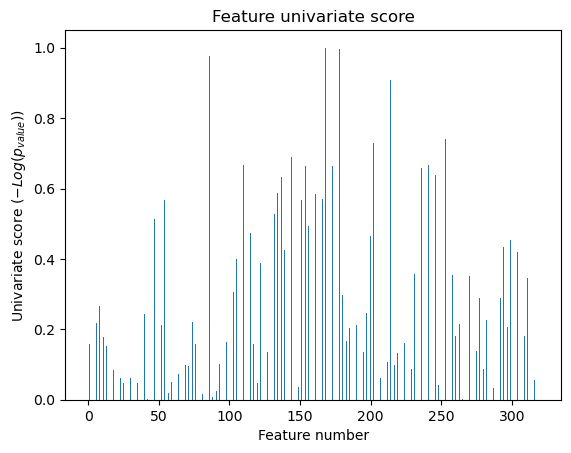

In [16]:
import matplotlib.pyplot as plt

X_indices = np.arange(X_original.shape[-1])
plt.figure(1)
plt.clf()
plt.bar(X_indices - 0.05, scores, width=0.2)
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
plt.show()

In [18]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = None
for i in range(1,52,5): #why 52 as above 0.6 threshold there are 51 features from the aboce graph
    selector = SelectKBest(f_classif, k=i)
    print("num features selected : ",i,":-_-:",evaluate_models_on_data_mod(X_normalized, Y_original,selector, random_state=42))

Starting model evaluation with test_size=0.2, random_state=42
----------------------------------------------------------------------
Data split: Train shape=(32, 1), Test shape=(8, 1)
----------------------------------------------------------------------
Evaluating Logistic Regression...
Train Metrics: {'Train Accuracy': 0.59375}
Validation Metrics: {'Validation Accuracy': 0.25}
----------------------------------------------------------------------
Evaluating SVM with kernel='linear'...
Train Metrics: {'Train Accuracy': 0.5625}
Validation Metrics: {'Validation Accuracy': 0.375}
----------------------------------------------------------------------
Evaluating SVM with kernel='poly'...
Train Metrics: {'Train Accuracy': 0.5625}
Validation Metrics: {'Validation Accuracy': 0.375}
----------------------------------------------------------------------
Evaluating SVM with kernel='rbf'...
Train Metrics: {'Train Accuracy': 0.59375}
Validation Metrics: {'Validation Accuracy': 0.375}
-------------

In [19]:
selected_features_ufs = X_original.columns[selector.get_support()]
print(selected_features_ufs)

Index(['alpha1', 'alpha2', 'alpha10', 'alpha15', 'alpha17', 'alpha18', 'beta5',
       'beta10', 'beta19', 'beta23', 'beta42', 'beta43', 'beta48', 'beta49',
       'beta50', 'beta63', 'beta64', 'delta11', 'delta23', 'delta27',
       'delta41', 'delta51', 'delta62', 'delta64', 'theta23', 'gamma4',
       'gamma5', 'gamma6', 'gamma7', 'gamma8', 'gamma9', 'gamma10', 'gamma16',
       'gamma19', 'gamma23', 'gamma25', 'gamma26', 'gamma28', 'gamma31',
       'gamma33', 'gamma34', 'gamma36', 'gamma38', 'gamma40', 'gamma42',
       'gamma43', 'gamma44', 'gamma45', 'gamma46', 'gamma47', 'gamma52'],
      dtype='object')


### Only a few features are important so will only try in range [5,20]

# RFE - Recursive feature selection

In [24]:
from sklearn.feature_selection import RFE

In [26]:
from sklearn.ensemble import RandomForestClassifier
estimator = svm.SVC(kernel='linear')
# estimator = KNeighborsClassifier(n_neighbors=3)
# estimator = LogisticRegression()|
# estimator = RandomForestClassifier()
selector = RFE(estimator,n_features_to_select=15,step=1)

In [27]:
selector

RFE(estimator=SVC(kernel='linear'), n_features_to_select=15)

In [30]:
evaluate_models_on_data_mod(X_original, Y_original,selector, random_state=42)

Starting model evaluation with test_size=0.2, random_state=42
----------------------------------------------------------------------
Data split: Train shape=(32, 15), Test shape=(8, 15)
----------------------------------------------------------------------
Evaluating Logistic Regression...
Train Metrics: {'Train Accuracy': 1.0}
Validation Metrics: {'Validation Accuracy': 0.5}
----------------------------------------------------------------------
Evaluating SVM with kernel='linear'...
Train Metrics: {'Train Accuracy': 1.0}
Validation Metrics: {'Validation Accuracy': 0.625}
----------------------------------------------------------------------
Evaluating SVM with kernel='poly'...
Train Metrics: {'Train Accuracy': 0.5625}
Validation Metrics: {'Validation Accuracy': 0.5}
----------------------------------------------------------------------
Evaluating SVM with kernel='rbf'...
Train Metrics: {'Train Accuracy': 0.5625}
Validation Metrics: {'Validation Accuracy': 0.625}
----------------------

In [31]:
selected_features_rfs = X_original.columns[selector.get_support()]
print(selected_features_rfs)

Index(['alpha46', 'beta10', 'beta39', 'delta2', 'delta13', 'delta29',
       'delta32', 'delta34', 'delta43', 'delta58', 'delta60', 'delta61',
       'theta55', 'theta62', 'gamma43'],
      dtype='object')


# PCA

In [35]:
from sklearn.decomposition import PCA
selector = PCA(n_components=15)
evaluate_models_on_data_mod(X_normalized,Y_original,selector,random_state=42)

Starting model evaluation with test_size=0.2, random_state=42
----------------------------------------------------------------------
Data split: Train shape=(32, 15), Test shape=(8, 15)
----------------------------------------------------------------------
Evaluating Logistic Regression...
Train Metrics: {'Train Accuracy': 0.84375}
Validation Metrics: {'Validation Accuracy': 0.0}
----------------------------------------------------------------------
Evaluating SVM with kernel='linear'...
Train Metrics: {'Train Accuracy': 0.8125}
Validation Metrics: {'Validation Accuracy': 0.0}
----------------------------------------------------------------------
Evaluating SVM with kernel='poly'...
Train Metrics: {'Train Accuracy': 0.625}
Validation Metrics: {'Validation Accuracy': 0.25}
----------------------------------------------------------------------
Evaluating SVM with kernel='rbf'...
Train Metrics: {'Train Accuracy': 0.6875}
Validation Metrics: {'Validation Accuracy': 0.25}
------------------

In [37]:
selected_features_pca = X_original.columns[:selector.n_components_]
print(selected_features_pca)

Index(['alpha1', 'alpha2', 'alpha3', 'alpha4', 'alpha5', 'alpha6', 'alpha7',
       'alpha8', 'alpha9', 'alpha10', 'alpha11', 'alpha12', 'alpha13',
       'alpha14', 'alpha15'],
      dtype='object')


In [39]:
selector.explained_variance_ratio_

array([0.30199677, 0.18373336, 0.14480242, 0.1082797 , 0.07219023,
       0.04861808, 0.0291648 , 0.0266982 , 0.01559159, 0.01279169,
       0.01058229, 0.00948653, 0.00663431, 0.00617598, 0.00437767])

# Top 5 features of all the three algos 

In [42]:
selector = SelectKBest(f_classif, k=5)
evaluate_models_on_data_mod(X_normalized, Y_original,selector, random_state=42)
selected_features_ufs = X_original.columns[selector.get_support()]
print(selected_features_ufs)

Starting model evaluation with test_size=0.2, random_state=42
----------------------------------------------------------------------
Data split: Train shape=(32, 5), Test shape=(8, 5)
----------------------------------------------------------------------
Evaluating Logistic Regression...
Train Metrics: {'Train Accuracy': 0.6875}
Validation Metrics: {'Validation Accuracy': 0.25}
----------------------------------------------------------------------
Evaluating SVM with kernel='linear'...
Train Metrics: {'Train Accuracy': 0.71875}
Validation Metrics: {'Validation Accuracy': 0.125}
----------------------------------------------------------------------
Evaluating SVM with kernel='poly'...
Train Metrics: {'Train Accuracy': 0.59375}
Validation Metrics: {'Validation Accuracy': 0.375}
----------------------------------------------------------------------
Evaluating SVM with kernel='rbf'...
Train Metrics: {'Train Accuracy': 0.71875}
Validation Metrics: {'Validation Accuracy': 0.25}
-------------

In [44]:
selector = RFE(estimator,n_features_to_select=5,step=1)
evaluate_models_on_data_mod(X_normalized, Y_original,selector, random_state=42)
selected_features_rfs = X_original.columns[selector.get_support()]
print(selected_features_rfs)

Starting model evaluation with test_size=0.2, random_state=42
----------------------------------------------------------------------
Data split: Train shape=(32, 5), Test shape=(8, 5)
----------------------------------------------------------------------
Evaluating Logistic Regression...
Train Metrics: {'Train Accuracy': 0.8125}
Validation Metrics: {'Validation Accuracy': 0.375}
----------------------------------------------------------------------
Evaluating SVM with kernel='linear'...
Train Metrics: {'Train Accuracy': 0.84375}
Validation Metrics: {'Validation Accuracy': 0.5}
----------------------------------------------------------------------
Evaluating SVM with kernel='poly'...
Train Metrics: {'Train Accuracy': 0.8125}
Validation Metrics: {'Validation Accuracy': 0.125}
----------------------------------------------------------------------
Evaluating SVM with kernel='rbf'...
Train Metrics: {'Train Accuracy': 0.8125}
Validation Metrics: {'Validation Accuracy': 0.25}
----------------

In [46]:
import numpy as np
selector = PCA(n_components=5)
evaluate_models_on_data_mod(X_normalized,Y_original,selector,random_state=42)
feature_importance = np.abs(selector.components_).sum(axis=0)
important_features = X_original.columns[np.argsort(-feature_importance)][:5]
print(important_features)

Starting model evaluation with test_size=0.2, random_state=42
----------------------------------------------------------------------
Data split: Train shape=(32, 5), Test shape=(8, 5)
----------------------------------------------------------------------
Evaluating Logistic Regression...
Train Metrics: {'Train Accuracy': 0.53125}
Validation Metrics: {'Validation Accuracy': 0.125}
----------------------------------------------------------------------
Evaluating SVM with kernel='linear'...
Train Metrics: {'Train Accuracy': 0.625}
Validation Metrics: {'Validation Accuracy': 0.375}
----------------------------------------------------------------------
Evaluating SVM with kernel='poly'...
Train Metrics: {'Train Accuracy': 0.625}
Validation Metrics: {'Validation Accuracy': 0.375}
----------------------------------------------------------------------
Evaluating SVM with kernel='rbf'...
Train Metrics: {'Train Accuracy': 0.625}
Validation Metrics: {'Validation Accuracy': 0.25}
-----------------